In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Overview

## Read the Dataset

In [2]:
column_names = [
    'ID',                    # Column 1: ID of the statement
    'Label',                 # Column 2: Label
    'Statement',             # Column 3: Statement
    'Subject',               # Column 4: Subject(s)
    'Speaker',               # Column 5: Speaker
    'Speaker Job Title',     # Column 6: Speaker's Job Title
    'State Info',            # Column 7: State Info
    'Party Affiliation',     # Column 8: Party Affiliation
    'Barely True Counts',    # Column 9: Barely True Counts
    'False Counts',          # Column 10: False Counts
    'Half True Counts',      # Column 11: Half True Counts
    'Mostly True Counts',    # Column 12: Mostly True Counts
    'Pants on Fire Counts',  # Column 13: Pants on Fire Counts
    'Context'                # Column 14: Context (venue / location of the speech or statement)
]

In [3]:
def read_dataframe(tsv_file: str) -> pd.DataFrame :
    """
    Read data from table
    Pre-process missing value
    """
    # creates a "dataframe" or "df" for short. This is similar to a 2-D python dict.
    df = pd.read_csv(tsv_file, delimiter='\t')
    ## Numerical Filled missing values with 0
    numeric_columns = df.select_dtypes(include=['number']).columns
    df[numeric_columns] = df[numeric_columns].fillna(0)
    ## Categorical Filled missing values with an empty string
    string_columns = df.select_dtypes(include=['object']).columns
    df[string_columns] = df[string_columns].fillna("")
    # labels the columns in the dataset using the data dictionary described in the README
    df.columns = column_names
    return df

In [4]:
df_train = read_dataframe('https://raw.githubusercontent.com/JessieLuo/AppliedMachineLearning/dev/data/train.tsv')
df_test = read_dataframe('https://raw.githubusercontent.com/JessieLuo/AppliedMachineLearning/dev/data/test.tsv')
df_valid = read_dataframe('https://raw.githubusercontent.com/JessieLuo/AppliedMachineLearning/dev/data/valid.tsv')

In [5]:
# df_train = read_dataframe('./data/train.tsv')
# df_test = read_dataframe('./data/test.tsv')
# df_valid = read_dataframe('./data/valid.tsv')

In [6]:
df_train.head()

,ID,Label,Statement,Subject,Speaker,Speaker Job Title,State Info,Party Affiliation,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10239 entries, 0 to 10238
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    10239 non-null  object 
 1   Label                 10239 non-null  object 
 2   Statement             10239 non-null  object 
 3   Subject               10239 non-null  object 
 4   Speaker               10239 non-null  object 
 5   Speaker Job Title     10239 non-null  object 
 6   State Info            10239 non-null  object 
 7   Party Affiliation     10239 non-null  object 
 8   Barely True Counts    10239 non-null  float64
 9   False Counts          10239 non-null  float64
 10  Half True Counts      10239 non-null  float64
 11  Mostly True Counts    10239 non-null  float64
 12  Pants on Fire Counts  10239 non-null  float64
 13  Context               10239 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


In [8]:
def show_news_article(input_df: pd.DataFrame, index: int) -> None:
    """
    Most relevant columns analysis

    Parameter
    ---------
    `index`: the row in original dataset
    """
    print(f"speaker: {input_df.iat[index, 4]}")
    print(f"subject(s): {input_df.iat[index, 3]}")
    print(f"statement: {input_df.iat[index, 2]}")
    print(f"label: {input_df.iat[index, 1]}")

In [9]:
show_news_article(df_train, 1)

speaker: barack-obama
subject(s): foreign-policy
statement: Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."
label: mostly-true


## EDA

#### Statement Analysis

In [10]:
def plotbh(df, col):
    """Draw boxplot and histogram for numerical variables"""
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    # Boxplot
    sns.boxplot(x=df[col], ax=axs[0])
    axs[0].set_title('Box chart of ' + col)

    # Histogram
    sns.histplot(data=df, x=col, kde=True, ax=axs[1])
    axs[1].set_title('Histogram of ' + col)

    plt.tight_layout()
    plt.show()

In [11]:
df_train['statement_words'] = df_train['Statement'].apply(lambda x : len(x.split()))
df_train['statement_words'].describe()

,statement_words
count,10239.000000
mean,18.010743
std,9.658795
min,2.000000
25%,12.000000
50%,17.000000
75%,22.000000
max,467.000000


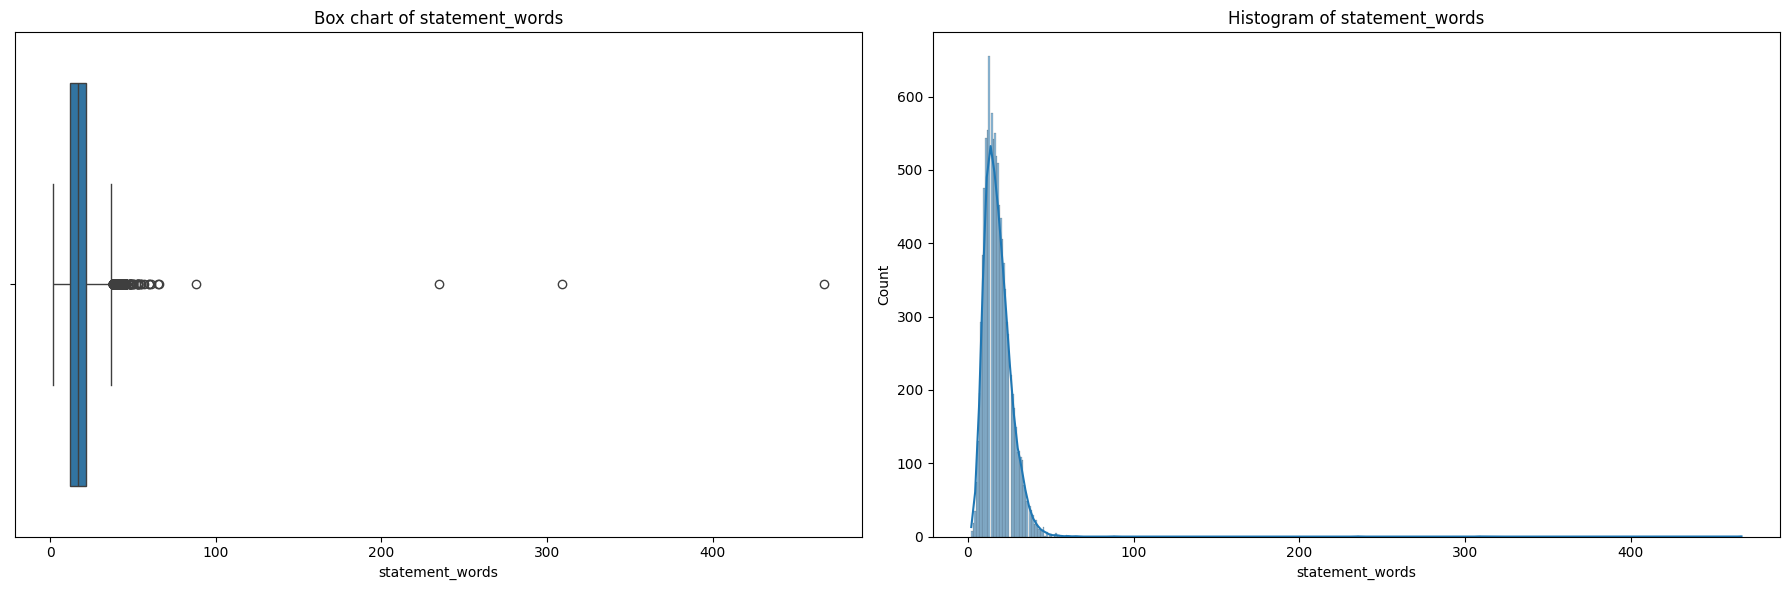

In [12]:
plotbh(df_train, 'statement_words')

In [13]:
# Get the list of English stopwords
stop_words = set(nltk.corpus.stopwords.words('english'))

# Define a function to clean and tokenize the statements
def statement_text_clean_and_tokenize(statement):
    """
    Only applied on `Statement` and only used for word frequency visualize
    """
    # Tokenize the statement
    statement_tokens = nltk.word_tokenize(statement)
    # Convert tokens to lowercase, remove stopwords, non-alphabetic characters, and punctuation
    cleaned_tokens = [
        statement_token.lower() for statement_token in statement_tokens
            if statement_token.lower() not in stop_words and statement_token.isalpha()
    ]
    return cleaned_tokens

# Apply the cleaning and tokenization function to the 'Statement' column
df_train['word_token'] = df_train['Statement'].apply(statement_text_clean_and_tokenize)

# Combine all cleaned tokens into one list of words
all_cleaned_words = df_train['word_token'].explode().tolist()

In [14]:
# Use Counter to count the frequency of each cleaned word
word_freq = Counter(all_cleaned_words)

# Convert to a DataFrame for easier analysis
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

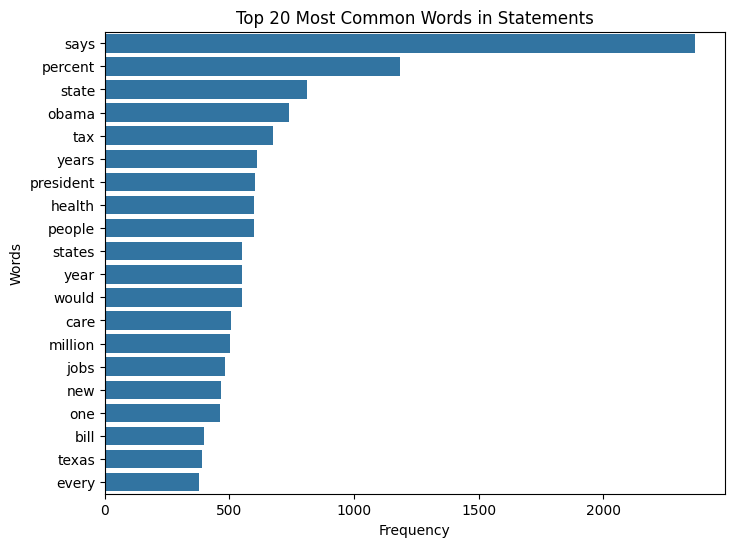

In [15]:
# Plot the most common words using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Frequency', y='Word', data=word_freq_df.head(20))
plt.title('Top 20 Most Common Words in Statements')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

#### Label Analysis

Categorical label: ['half-true', 'mostly-true', 'false', 'true', 'barely-true', 'pants-fire']. They are in same column

Numerical label has separated columns, they are ['Barely True Counts', 'False Counts', 'Half True Counts', 'Mostly True Counts', 'Pants on Fire Counts']

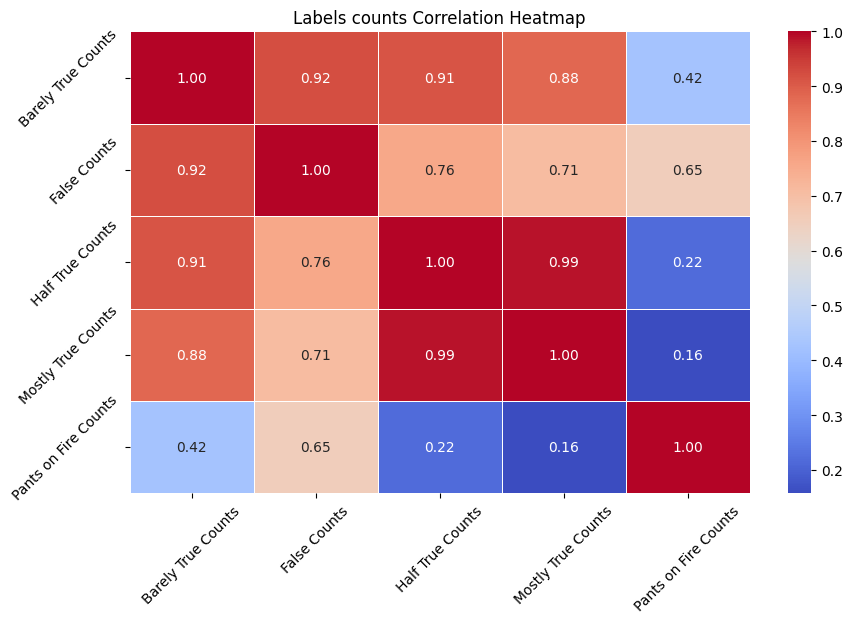

In [16]:
labels_count = ['Barely True Counts', 'False Counts', 'Half True Counts', 'Mostly True Counts', 'Pants on Fire Counts']

# Calculate the correlation matrix
correlation_matrix = df_train[labels_count].corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Labels counts Correlation Heatmap')

plt.show()

This the numerical label of LIAR

The labels "Barely True," "False," "Half True," and "Mostly True" are highly correlated, suggesting that they often overlap or represent similar levels of truthfulness in statements.

"Pants on Fire" shows a weaker correlation with the other labels, indicating that it might capture a more extreme or different kind of falseness compared to the other categories.


Code idea comes from [Kaggle](https://www.kaggle.com/code/hendrixwilsonj/liar-data-analysis#Exporting-our-model)

The following analysis are based on the categorical label

In [17]:
def label_bar_chart(input_df: pd.DataFrame, title: str = "LIAR Dataset") -> None:
    """
    Label distribution
    """
    # computes frequencies of labels and converts to percentages
    label_frequencies = input_df['Label'].value_counts(normalize=True)

    def multiply_100(x):
        return x * 100

    # "apply" is a handy way to call a function on every row of data.
    label_frequencies = label_frequencies.apply(multiply_100)

    # bar chart ordering and  colors for readability.
    labels = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
    colors = [
        'orangered', # pants-fire
        'coral', # false
        'salmon', # barely-true
        'peachpuff', # half-true
        'skyblue', # mostly-true
        'deepskyblue', # true
    ]
    label_frequencies = label_frequencies.reindex(index = labels)

    # creates a horizontal bar chart with a descriptive title
    axis = label_frequencies.plot(kind='barh', figsize=(8, 4), color=colors)
    axis.set_xlabel('Percentage')
    axis.set_title(f"Distribution of label values [{title}, sample_size={len(input_df)}]", size=10)

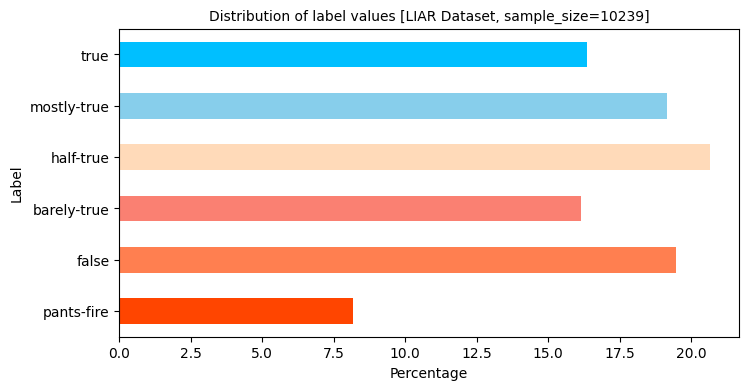

In [18]:
label_bar_chart(df_train)

#### Speaker Analysis

In [19]:
num_speakers = df_train['Speaker'].nunique()
avg_statments = len(df_train) / num_speakers

print(f"Unique speakers in dataset: {num_speakers}")
print(f"Average statements made per speaker: {avg_statments}")

Unique speakers in dataset: 2910
Average statements made per speaker: 3.5185567010309278


In [20]:
speaker_lists = df_train['Speaker'].unique().tolist()
speaker_lists[:5]

['scott-surovell',
 'barack-obama',
 'blog-posting',
 'charlie-crist',
 'robin-vos']

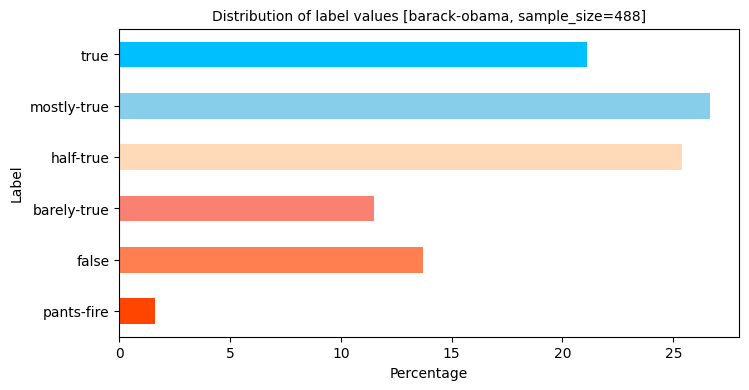

In [21]:
def speaker_bar_chart(input_df: pd.DataFrame, speaker: str) -> pd.DataFrame:
    """
    Label distribution by Speaker
    """
    # filters the input_df
    speaker_df = input_df[ input_df['Speaker'] == speaker ]
    speaker_df.reset_index(inplace=True)

    # calls the bar chart function we created earlier
    label_bar_chart(speaker_df, title=speaker)

    return speaker_df


# create a bar chart over labels for a single speaker. Store the returned dataframe to a variable.
speak_ret_df = speaker_bar_chart(df_train, 'barack-obama')

#### Subject Analysis

In [22]:
# creates a new dataframe that only contains the label and subjects columns.
subject_df = df_train[['Label', 'Subject']].copy()


def csv_to_list(x):
    # start by turning the comma-separated values into a list of values
    return x.split(",")


subject_df['Subject'] = subject_df['Subject'].apply(csv_to_list)

subject_df = subject_df.explode('Subject')

subject_df.head()

,Label,Subject
0,half-true,energy
0,half-true,history
0,half-true,job-accomplishments
1,mostly-true,foreign-policy
2,false,health-care


In [23]:
num_unique_subjects = subject_df['Subject'].nunique()

print(f"Unique subjects in dataset: {num_unique_subjects}")

Unique subjects in dataset: 143


In [24]:
subject_lists = subject_df['Subject'].unique().tolist()
num = 5
print(f"{num} example subjects:")
subject_lists[:num]

5 example subjects:


['energy', 'history', 'job-accomplishments', 'foreign-policy', 'health-care']

In [25]:
def subject_bar_chart(input_df: pd.DataFrame, subject: str) -> pd.DataFrame:

    # filters the input_df
    ret_df = input_df[ input_df['Subject'] == subject ]
    ret_df.reset_index(inplace=True)

    # calls the bar chart function we created earlier
    label_bar_chart(ret_df, title=subject)

    return ret_df


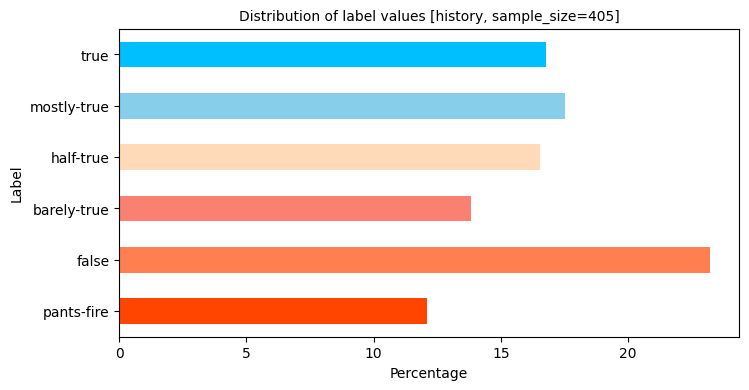

In [26]:
# create a bar chart over labels for a single subject. Store the returned dataframe to a variable.
sub_ret_df = subject_bar_chart(subject_df, 'history')

# Feature Engineering

## Traditional Model & Deep Learning Pre-processing

In [27]:
# Prepare dataFrame
text_columns = ['Statement', 'Subject', 'Speaker', 'Context']
label_columns = ['Label']
ml_model_data = df_train[label_columns + text_columns].copy()
ml_valid_data = df_valid[label_columns + text_columns].copy()
ml_test_data = df_test[label_columns + text_columns].copy()

### Traditional NLP text cleaning

In [28]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

def clean_text_ml(text):
    """
    The traditional NLP text preprocessing applied for traditional ML model

    For instance, SVM, or Linear Regression for classification
    """
    # Initialize NLTK components
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    # Lowercase the text
    text = text.lower()

    # Tokenize and remove punctuation using RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)

    # Remove stopwords and apply stemming
    words = [stemmer.stem(word) for word in words if word not in stop_words]

    # Rejoin words into a single string
    return ' '.join(words)

In [29]:
# Prepare cleaned statement
def generate_clean_text(df):
    df['cleaned_statement_text'] = df['Statement'].apply(clean_text_ml)

for data in [ml_model_data, ml_test_data, ml_valid_data]:
    generate_clean_text(data)

### Word Embedding for represent text

Due to the `word2vec-google-news-300` the paper used is too old so that difficult to import it. Training an embedding based on the LIAR itself to replace original idea.

In [30]:
from gensim.models import Word2Vec
from nltk import word_tokenize

In [31]:
def clean_text_dl(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())  # Convert to lowercase and tokenize
    return tokens

# DL Prepare cleaned statement
def generate_clean_text_dl(df):
    df['tokenized_statement'] = df['Statement'].apply(clean_text_dl)

for data in [ml_model_data, ml_test_data, ml_valid_data]:
    generate_clean_text_dl(data)

In [32]:
# Prepare the sentences for Word2Vec (list of token lists)
sentences = ml_model_data['tokenized_statement'].tolist()

# Train the Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Save the model
word2vec_model.save("./models/word2vec_embedding.model")

## LLM pre-processing

#### Data Preprocessing

In [33]:
def preprocess_text(text):
    """
    Applied on the text which be used on Transformer model
    """
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\[.*?\]', '', text)  # Remove text inside brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    return text.strip()

df_train['Processed_Statement'] = df_train['Statement'].apply(preprocess_text)

In [34]:
print(df_train['Processed_Statement'].iloc[:1].tolist())

['when did the decline of coal start? it started when natural gas took off that started to begin in (president george w.) bushs administration.']


In [35]:
# Concatenating Text Features
df_train['text'] = df_train['Speaker'] + ", " + df_train['Subject'] + ", " + df_train['Processed_Statement']

In [36]:
print(df_train['text'].iloc[:1].tolist())

['scott-surovell, energy,history,job-accomplishments, when did the decline of coal start? it started when natural gas took off that started to begin in (president george w.) bushs administration.']


#### Tokenization

In [37]:
from transformers import BertTokenizer

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [38]:
# Tokenize the combined text
encoded_inputs = tokenizer(
    df_train['text'].tolist(),
    max_length=128,
    padding=True,
    truncation=True,
    return_tensors='pt'
)

# These tensors will model inputs
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

In [39]:
for i in range(2):
    # Decode the input_ids back to tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[i])

    print(f"Example {i+1}:")
    print(f"Tokens: {tokens}")
    print(f"Input IDs: {input_ids[i].tolist()}")
    print(f"Attention Mask: {attention_masks[i].tolist()}")
    print("\n")

Example 1:
Tokens: ['[CLS]', 'scott', '-', 'sur', '##ove', '##ll', ',', 'energy', ',', 'history', ',', 'job', '-', 'accomplishments', ',', 'when', 'did', 'the', 'decline', 'of', 'coal', 'start', '?', 'it', 'started', 'when', 'natural', 'gas', 'took', 'off', 'that', 'started', 'to', 'begin', 'in', '(', 'president', 'george', 'w', '.', ')', 'bush', '##s', 'administration', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 

So much number of [PAD] to make the input align the BERT pre-defined token length 512. All input sequences in a batch to have the same length.

# Model Construction

## Original Paper Work

### Pre-processing for ML

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder


In [41]:
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # max_features need adjust

train_X = vectorizer.fit_transform(ml_model_data['cleaned_statement_text'])

# Encode label
def encode_label(df):
    le = LabelEncoder()
    df['encoded_label'] = le.fit_transform(df['Label'])
    return le  # convince for report show target name


for data in [ml_model_data, ml_valid_data, ml_test_data]:
    label_encoder = encode_label(data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    train_X, ml_model_data['encoded_label'], test_size=0.2, random_state=42
)

### SVM

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import pickle

In [43]:
# # Define the parameter grid for tuning
# param_grid = {
#     'C': [0.1, 1, 10, 100],  # Regularization parameter for SVM
#     'kernel': ['linear', 'rbf'],  # SVM kernel
#     'gamma': ['scale', 'auto'],  # Kernel coefficient
# }

# # Initialize the SVM model
# svm = SVC()

# # Use GridSearchCV to tune hyperparameters
# grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Best hyperparameters found
# print("Best Hyperparameters:", grid_search.best_params_)

# # Save the best parameters found by GridSearchCV
# best_params = grid_search.best_params_

# # Save to a file using pickle
# with open('./models/best_svm_params.pkl', 'wb') as f:
#     pickle.dump(best_params, f)

In [44]:
# Load the best parameters from the file
# URL: https://github.com/JessieLuo/AppliedMachineLearning/blob/dev/models/best_svm_params.pkl
with open('./models/best_svm_params.pkl', 'rb') as f:
    loaded_params = pickle.load(f)

svm_loaded = SVC(**loaded_params)
svm_loaded.fit(X_train, y_train)

SVC(C=1)

In [45]:
# Evaluate on the validation set
Valid_X = vectorizer.transform(ml_valid_data['cleaned_statement_text']) # Carefully use transform() not fit_transform() to avoid re-fit the words
Valid_y = ml_valid_data['encoded_label']

Valid_y_pred = svm_loaded.predict(Valid_X)
print("Validation Set Accuracy:", accuracy_score(Valid_y, Valid_y_pred))
print("Validation Set Classification Report:\n", classification_report(Valid_y, Valid_y_pred, target_names=label_encoder.classes_))


Validation Set Accuracy: 0.23460639127045985
Validation Set Classification Report:
               precision    recall  f1-score   support

 barely-true       0.26      0.12      0.17       236
       false       0.25      0.38      0.30       263
   half-true       0.21      0.33      0.25       248
 mostly-true       0.24      0.24      0.24       251
  pants-fire       0.75      0.03      0.05       116
        true       0.23      0.16      0.19       169

    accuracy                           0.23      1283
   macro avg       0.32      0.21      0.20      1283
weighted avg       0.28      0.23      0.22      1283



In [46]:
# Evaluate on the test set
Test_X = vectorizer.transform(ml_test_data['cleaned_statement_text'])
Test_y = ml_test_data['encoded_label']
Test_y_pred = svm_loaded.predict(Test_X)
print("Test Set Accuracy:", accuracy_score(Test_y, Test_y_pred))
print("Test Set Classification Report:\n", classification_report(Test_y, Test_y_pred, target_names=label_encoder.classes_))


Test Set Accuracy: 0.23064770932069512
Test Set Classification Report:
               precision    recall  f1-score   support

 barely-true       0.26      0.13      0.17       212
       false       0.23      0.32      0.27       249
   half-true       0.24      0.36      0.29       265
 mostly-true       0.20      0.23      0.21       241
  pants-fire       0.50      0.03      0.06        92
        true       0.23      0.15      0.18       207

    accuracy                           0.23      1266
   macro avg       0.28      0.20      0.20      1266
weighted avg       0.25      0.23      0.22      1266



### Linear Regression

In [47]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)

In [48]:
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [49]:
# Evaluate on the validation set
Valid_X = vectorizer.transform(ml_valid_data['cleaned_statement_text']) # Carefully use transform() not fit_transform() to avoid re-fit the words
Valid_y = ml_valid_data['encoded_label']
Valid_y_pred = log_reg.predict(Valid_X)
print("Validation Set Accuracy (LR):", accuracy_score(Valid_y, Valid_y_pred))
print("Validation Set Classification Report (LR):\n", classification_report(Valid_y, Valid_y_pred, target_names=label_encoder.classes_))


Validation Set Accuracy (LR): 0.22759158222915044
Validation Set Classification Report (LR):
               precision    recall  f1-score   support

 barely-true       0.19      0.14      0.16       236
       false       0.27      0.35      0.30       263
   half-true       0.21      0.26      0.23       248
 mostly-true       0.23      0.24      0.24       251
  pants-fire       0.45      0.08      0.13       116
        true       0.19      0.20      0.19       169

    accuracy                           0.23      1283
   macro avg       0.26      0.21      0.21      1283
weighted avg       0.24      0.23      0.22      1283



In [50]:
Test_X = vectorizer.transform(ml_test_data['cleaned_statement_text'])
Test_y = ml_test_data['encoded_label']
Test_y_pred = log_reg.predict(Test_X)
print("Test Set Accuracy (LR):", accuracy_score(Test_y, Test_y_pred))
print("Test Set Classification Report (LR):\n", classification_report(Test_y, Test_y_pred, target_names=label_encoder.classes_))

Test Set Accuracy (LR): 0.21958925750394945
Test Set Classification Report (LR):
               precision    recall  f1-score   support

 barely-true       0.22      0.16      0.18       212
       false       0.26      0.29      0.27       249
   half-true       0.22      0.29      0.25       265
 mostly-true       0.20      0.24      0.22       241
  pants-fire       0.12      0.02      0.04        92
        true       0.19      0.18      0.19       207

    accuracy                           0.22      1266
   macro avg       0.20      0.20      0.19      1266
weighted avg       0.21      0.22      0.21      1266



### Pre-Processing for DL

In [51]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [52]:
# !important run this on colab to enable GPU
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Num GPUs Available:  1
TensorFlow version: 2.17.0
GPU is available
1 Physical GPUs, 1 Logical GPUs


In [53]:
# Prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(ml_model_data['Statement'])

# Use the Tokenizer's vocab size, which might differ from the Word2Vec vocab size
tokenizer_vocab_size = len(tokenizer.word_index)
embedding_dim = word2vec_model.vector_size

print(tokenizer_vocab_size, embedding_dim)

12407 100


In [54]:
# Prepare the embedding matrix based on the tokenizer's vocab size
embedding_matrix = np.zeros((tokenizer_vocab_size + 1, embedding_dim))

print(tokenizer_vocab_size, embedding_matrix.shape)

12407 (12408, 100)


In [55]:
for word, i in tokenizer.word_index.items():
    if i > tokenizer_vocab_size:
        continue
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        # Words not found in the Word2Vec model will remain as zero vectors
        pass


In [56]:
# Convert text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(ml_model_data['Statement'])
valid_sequences = tokenizer.texts_to_sequences(ml_valid_data['Statement'])
test_sequences = tokenizer.texts_to_sequences(ml_test_data['Statement'])

In [57]:
# Pad sequences to ensure they are all the same length
max_length = max(len(seq) for seq in train_sequences)
X_train = pad_sequences(train_sequences, maxlen=max_length, padding='post')
X_valid = pad_sequences(valid_sequences, maxlen=max_length, padding='post')
X_test = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Encode labels (assuming label_encoder is already fitted)
y_train = ml_model_data['encoded_label']
y_valid = ml_valid_data['encoded_label']
y_test = ml_test_data['encoded_label']

### Bi-LSTMs

In [58]:
import numpy as np
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
import pickle


In [59]:
class BiLSTMModel:
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, max_length, num_classes):
        """
        Initializes the Bi-LSTM model.

        Parameters:
        
        - vocab_size: Size of the vocabulary.
        - embedding_dim: Dimension of the word embeddings.
        - embedding_matrix: Pre-trained word embeddings.
        - max_length: Maximum length of input sequences.
        - num_classes: Number of classes for classification.
            - len(label_encoder.classes_)
        
        """
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embedding_matrix = embedding_matrix
        self.max_length = max_length
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def build_model(self):
        """Builds the Bi-LSTM model architecture."""
        model = Sequential()
        model.add(tf.keras.layers.Input(shape=(self.max_length,)))
        model.add(Embedding(input_dim=self.vocab_size + 1,
                            output_dim=self.embedding_dim,
                            embeddings_initializer=Constant(self.embedding_matrix),
                            trainable=False))
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Dropout(0.5))
        model.add(Bidirectional(LSTM(128)))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes, activation='softmax'))

        self.model = model
        return self.model

    def compile_model(self):
        """Compiles the Bi-LSTM model."""
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return self.model

    def train_model(self, X_train, y_train, X_valid, y_valid, epochs=5, batch_size=64):
        """Trains the Bi-LSTM model."""
        self.history = self.model.fit(X_train, y_train,
                                      epochs=epochs,
                                      batch_size=batch_size,
                                      validation_data=(X_valid, y_valid),
                                      verbose=1)
        return self.history

    def save_model(self, model_path='./models/biLSTM_model.keras', history_path='./models/biLSTM_model_history.pkl'):
        """Saves the model and training history."""
        self.model.save(model_path)
        with open(history_path, 'wb') as file_pi:
            pickle.dump(self.history.history, file_pi)

    def load_model(self, model_path='./models/biLSTM_model.keras', history_path='./models/biLSTM_model_history.pkl'):
        """Loads the model and training history."""
        self.model = tf.keras.models.load_model(model_path)
        with open(history_path, 'rb') as file_pi:
            self.history = pickle.load(file_pi)
        return self.model, self.history

    def evaluate_model(self, X_test, y_test):
        """Evaluates the model on the test data."""
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        return loss, accuracy

    def predict(self, X):
        """Makes predictions on the given input data."""
        return np.argmax(self.model.predict(X), axis=-1)

    def summary(self):
        """Prints the model summary."""
        return self.model.summary()


In [60]:
# Example usage:
# Assuming vocab_size, embedding_dim, embedding_matrix, max_length, and num_classes are defined.

# Initialize the model
bi_lstm = BiLSTMModel(tokenizer_vocab_size, embedding_dim, embedding_matrix, max_length, len(label_encoder.classes_))

# # Build the model
# bi_lstm.build_model()

# # Compile the model
# bi_lstm.compile_model()

# # Display the model summary
# bi_lstm.summary()

# # Train the model
# bi_lstm.train_model(X_train, y_train, X_valid, y_valid, epochs=5, batch_size=64)

# # Save the model and history
# bi_lstm.save_model()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 540, 100)            │       1,240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 540, 256)            │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 540, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,903,206 (7.26 MB)

 Trainable params: 662,406 (2.53 MB)

 Non-trainable params: 1,240,800 (4.73 MB)

Epoch 1/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.2089 - loss: 1.7627 - val_accuracy: 0.2299 - val_loss: 1.7427
Epoch 2/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.2102 - loss: 1.7422 - val_accuracy: 0.2362 - val_loss: 1.7390
Epoch 3/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.2216 - loss: 1.7427 - val_accuracy: 0.2385 - val_loss: 1.7295
Epoch 4/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.2367 - loss: 1.7337 - val_accuracy: 0.2330 - val_loss: 1.7231
Epoch 5/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.2259 - loss: 1.7318 - val_accuracy: 0.2455 - val_loss: 1.7227


In [65]:
# Later, load the model and history
bi_lstm.load_model()

# Evaluate the model
test_loss, test_accuracy = bi_lstm.evaluate_model(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Make predictions
predictions = bi_lstm.predict(X_test)


Test Accuracy: 0.2354
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


In [66]:
# Predict on the test set
y_test_pred = bi_lstm.predict(X_test)

# Generate classification report
print("Test Set Classification Report:\n", classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Test Set Classification Report:
               precision    recall  f1-score   support

 barely-true       1.00      0.00      0.01       212
       false       0.23      0.63      0.33       249
   half-true       0.24      0.26      0.25       265
 mostly-true       0.25      0.30      0.27       241
  pants-fire       0.00      0.00      0.00        92
        true       0.00      0.00      0.00       207

    accuracy                           0.24      1266
   macro avg       0.29      0.20      0.14      1266
weighted avg       0.31      0.24      0.17      1266



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### CNNs

## Transformer Model